# Animal Future data analysis

Notebook for the analysis of the analysis of the survey data collected in the scope of the Animal Future project for Portugal. 

**Objective**: understand which are the indicators that influenced past adoption of SBP. The goal is to replace the education level as proxy indicator for the risk aversion of farmers.

**Note**: the notebok is divided into two sections, the first with an analysis on all the 43 farmers and the second considering the additional data available only for 31 of them.

In [1]:
import pandas as pd

In [2]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Data ingestion

### Area use data

In [156]:
path_area_data = '../survey-data/43_Areas_POR_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'AREA_ID', 'Surface']
area_data_original = pd.read_excel(path_area_data, sheet_name='Main', index_col=0, usecols=columns_to_fetch)
area_data_original = area_data_original.drop('PT00')

Get label:
* 1 if the farm has any sown permanent pasture
* 0 otherwise

In [160]:
area_data_SBP_or_not = area_data_original['AREA_ID'].str.contains('Sown permanent pasture')
area_data_SBP_or_not = area_data_SBP_or_not.groupby('FARM_ID').any()

area_data = pd.DataFrame()
area_data['AdoptedSBP'] = area_data_SBP_or_not.astype(int)

In [161]:
area_data.head()

,AdoptedSBP
FARM_ID,
PT01,0
PT02,0
PT03,1
PT04,1
PT05,0


Get total pasture area

In [162]:
area_data_original = area_data_original[area_data_original['AREA_ID'].str.contains('pasture')]
area_data['PastureSurface'] = area_data_original.groupby('FARM_ID')['Surface'].sum()

area_data.head()

,AdoptedSBP,PastureSurface
FARM_ID,,
PT01,0,60.90
PT02,0,364.00
PT03,1,3450.44
PT04,1,160.40
PT05,0,457.37


### Livestock data

In [5]:
path_animal_data = '../survey-data/43_AnimalCategories_POR_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'LivestockType', 'AverageNumber']
animal_data_original = pd.read_excel(path_animal_data, sheet_name='Main', index_col=0, usecols=columns_to_fetch)
animal_data_original = animal_data_original.drop('PT00') # Drop farm 00, not relevant for the analysis

Get percentage of cattle for each farm

In [6]:
total_animals = animal_data_original.groupby('FARM_ID')['AverageNumber'].sum().rename('AverageAnimals')

total_animals_per_type = animal_data_original.groupby(['FARM_ID', 'LivestockType'], as_index=True).sum()
total_cattle = total_animals_per_type.query('LivestockType == "Cattle"').rename(columns={'AverageNumber': 'AverageCattle'})

total_animal_cattle = pd.merge(total_animals, total_cattle, on='FARM_ID', how='outer')
total_animal_cattle = total_animal_cattle.fillna(0)

In [7]:
animal_data = pd.DataFrame()
animal_data['CattlePercentage'] = total_animal_cattle['AverageCattle'] / total_animal_cattle['AverageAnimals']

animal_data.head()

,CattlePercentage
FARM_ID,
PT01,0.000000
PT02,0.000000
PT03,1.000000
PT04,1.000000
PT05,0.410191


### Location data

**Note**: 'PT35' had a white space in the excel file after the name that made it disappear when merging the datasets.

In [106]:
path_location_data = '../survey-data/Farms_Location.xls'
columns_to_fetch = ['FARM_ID', 'Distrito', 'Concelho']
# Imported without FARM_ID as index since need to be fixed before
location_data = pd.read_excel(path_location_data, usecols=columns_to_fetch) 

location_data.head()

,FARM_ID,Distrito,Concelho
0,PT1,Portalegre,Elvas
1,PT2,Setúbal,Grândola
2,PT3,Santarém,Benavente
3,PT4,Setúbal,Montijo
4,PT5,Évora,Montemor


In [107]:
num_idx = 2
for idx in range(len(location_data['FARM_ID'])):
    if len(location_data['FARM_ID'][idx]) == 3:
        location_data['FARM_ID'][idx] = location_data['FARM_ID'][idx][:num_idx] + '0' + location_data['FARM_ID'][idx][num_idx:]

In [108]:
location_data = location_data.set_index('FARM_ID')

In [111]:
location_data.head()

,Distrito,Concelho
FARM_ID,,
PT01,Portalegre,Elvas
PT02,Setúbal,Grândola
PT03,Santarém,Benavente
PT04,Setúbal,Montijo
PT05,Évora,Montemor


### Farms general data

In [50]:
path_general_data = '../survey-data/31_FarmsGeneral_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'OwnLand', 'RentedLand', 'LegalForm','FarmerSince']
general_data_original = pd.read_excel(path_general_data, index_col=0, usecols=columns_to_fetch)
general_data_original = general_data_original.drop('PT00')

Get percentage of rented land over total one

In [73]:
general_data = general_data_original[['LegalForm', 'FarmerSince']]
general_data['PercentRentedLand'] = general_data_original['RentedLand'] / (general_data_original['OwnLand'] + general_data_original['RentedLand'])

general_data.head()

c:\users\giaco\.virtualenvs\mixed-abm-phbhzcqt\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,LegalForm,FarmerSince,PercentRentedLand
FARM_ID,,,
PT02,Individual,29,0.0
PT13,Sociedade Agrícola,11,0.0
PT15,Sociedade Agrícola,11,1.0
PT16,Individual,3,1.0
PT17,Sociedade Agrícola,10,1.0


### Education data

In [72]:
path_education_data = '../survey-data/31_Social_Education_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'HighestEducationalDegree', 'HighestAgriculturalEducationalDegree']
education_data = pd.read_excel(path_education_data, index_col=0, usecols=columns_to_fetch)
education_data = education_data.drop('PT00')
education_data['HighestAgriculturalEducationalDegree'] = education_data['HighestAgriculturalEducationalDegree'].fillna('None')

education_data.head()

,HighestEducationalDegree,HighestAgriculturalEducationalDegree
FARM_ID,,
PT02,Undergraduate,Undergraduate
PT13,Undergraduate,Undergraduate
PT15,Undergraduate,Undergraduate
PT16,Undergraduate,Undergraduate
PT17,Undergraduate,None


### Succession data

In [69]:
path_succession_data = '../survey-data/31_Social_Succession_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'ExpectationFarmSuccession']
succession_data = pd.read_excel(path_succession_data, index_col=0, usecols=columns_to_fetch)
succession_data = succession_data.drop('PT00')

Replace numbers with the correspondent category

In [70]:
succession_data['ExpectationFarmSuccession'].value_counts()

2    20
1     9
5     1
Name: ExpectationFarmSuccession, dtype: int64

In [71]:
mapping = {1: 'NoExpectation', 2: 'FamilyInheritance', 5: 'NoExpectation'}
# Since we have only one instance that answered 5 (that would be 'Other'), we make it fall in the category NoExpectation
succession_data = succession_data['ExpectationFarmSuccession'].replace(mapping)

succession_data.head()

FARM_ID
PT02    FamilyInheritance
PT13    FamilyInheritance
PT15    FamilyInheritance
PT16    FamilyInheritance
PT17    FamilyInheritance
Name: ExpectationFarmSuccession, dtype: object

# Analysis on data for 30 farmers

In [163]:
import functools

In [164]:
farms_dataframes = [area_data, animal_data, location_data, general_data, education_data, succession_data]
farms30 = functools.reduce(lambda left, right: pd.merge(left, right, on='FARM_ID'), farms_dataframes)

farms30.head()

,AdoptedSBP,PastureSurface,CattlePercentage,Distrito,Concelho,LegalForm,FarmerSince,PercentRentedLand,HighestEducationalDegree,HighestAgriculturalEducationalDegree,ExpectationFarmSuccession
FARM_ID,,,,,,,,,,,
PT02,0,364.00,0.0,Setúbal,Grândola,Individual,29,0.0,Undergraduate,Undergraduate,FamilyInheritance
PT13,1,542.58,1.0,Portalegre,Avis,Sociedade Agrícola,11,0.0,Undergraduate,Undergraduate,FamilyInheritance
PT15,1,262.70,1.0,Portalegre,Monforte,Sociedade Agrícola,11,1.0,Undergraduate,Undergraduate,FamilyInheritance
PT16,0,23.00,1.0,Évora,Évora,Individual,3,1.0,Undergraduate,Undergraduate,FamilyInheritance
PT17,1,250.00,1.0,Évora,Montemor,Sociedade Agrícola,10,1.0,Undergraduate,None,FamilyInheritance


## Data exploration

In [165]:
farms30.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, PT02 to PT43
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   AdoptedSBP                            30 non-null     int32  
 1   PastureSurface                        30 non-null     float64
 2   CattlePercentage                      30 non-null     float64
 3   Distrito                              30 non-null     object 
 4   Concelho                              30 non-null     object 
 5   LegalForm                             30 non-null     object 
 6   FarmerSince                           30 non-null     int64  
 7   PercentRentedLand                     30 non-null     float64
 8   HighestEducationalDegree              30 non-null     object 
 9   HighestAgriculturalEducationalDegree  30 non-null     object 
 10  ExpectationFarmSuccession             30 non-null     object 
dtypes: float64(3), int32(

In [166]:
farms30.describe()

,AdoptedSBP,PastureSurface,CattlePercentage,FarmerSince,PercentRentedLand
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.566667,509.447667,0.810436,16.033333,0.248616
std,0.504007,618.480397,0.346573,11.505571,0.411126
min,0.000000,23.000000,0.000000,1.000000,0.000000
25%,0.000000,141.250000,0.739726,8.000000,0.000000
50%,1.000000,316.000000,1.000000,11.000000,0.000000
75%,1.000000,424.920000,1.000000,25.750000,0.371753
max,1.000000,2500.000000,1.000000,40.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A18AB16A58>,
      dtype=object)

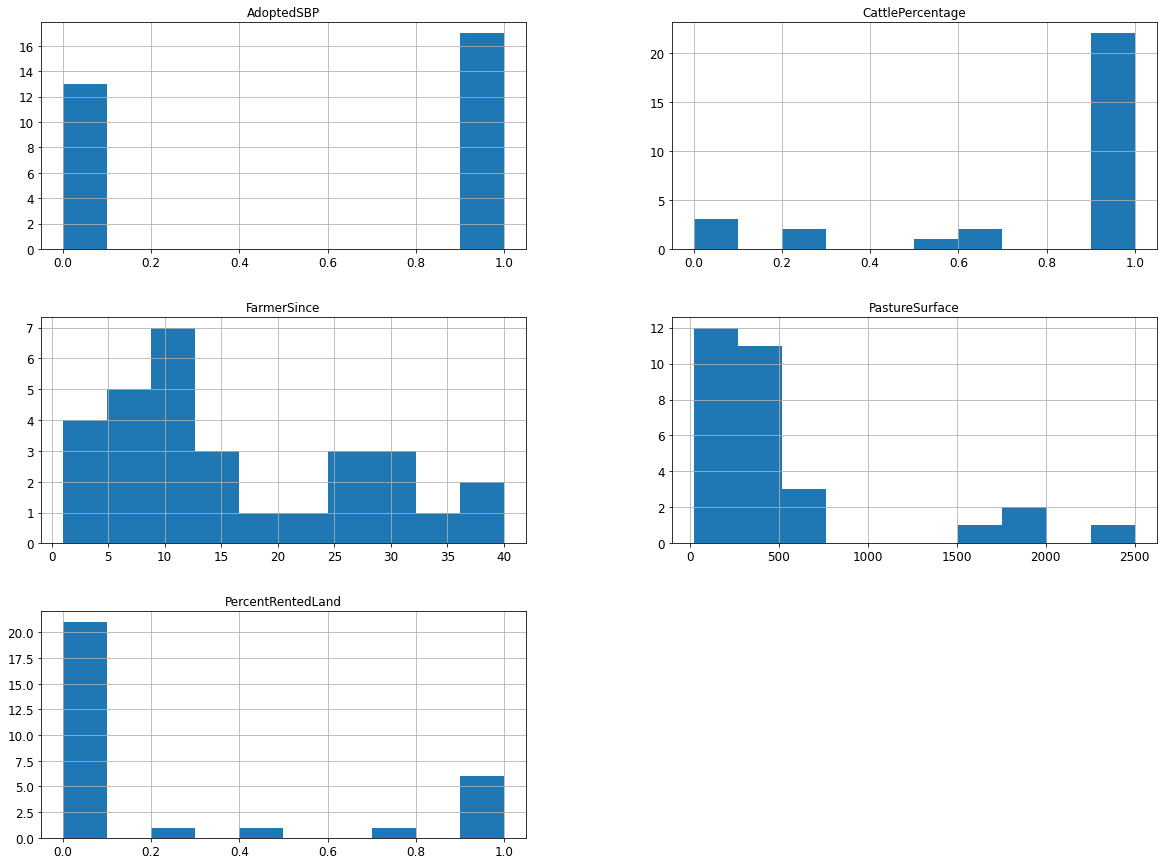

In [167]:
farms30.hist(figsize=(20,15))

In [127]:
farms30['Distrito'].value_counts()

Évora         13
Beja           8
Setúbal        4
Portalegre     4
Santarém       1
Name: Distrito, dtype: int64

In [128]:
farms30['Concelho'].value_counts()

Montemor                6
Évora                   5
Beja                    2
Monforte                1
Serpa                   1
Arraiolos               1
Aljustrel               1
Portel                  1
Ferreira do Alentejo    1
Alvito                  1
Arronches               1
Alcácer do Sal          1
Coruche                 1
Castro Verde            1
Ourique                 1
Avis                    1
Elvas                   1
Montijo                 1
Santiago do Cacém       1
Grândola                1
Name: Concelho, dtype: int64

In [129]:
farms30['LegalForm'].value_counts()

Sociedade Agrícola    20
Individual             8
ENI                    1
Cooperativa Social     1
Name: LegalForm, dtype: int64

In [130]:
farms30['HighestEducationalDegree'].value_counts()

Undergraduate    14
Graduate         13
Secondary         2
Primary           1
Name: HighestEducationalDegree, dtype: int64

In [131]:
farms30['HighestAgriculturalEducationalDegree'].value_counts()

Undergraduate    13
Graduate         11
None              6
Name: HighestAgriculturalEducationalDegree, dtype: int64

In [132]:
farms30['ExpectationFarmSuccession'].value_counts()

FamilyInheritance    20
NoExpectation        10
Name: ExpectationFarmSuccession, dtype: int64

### Correlations

In [168]:
corr_matrix = farms30.corr()
corr_matrix

,AdoptedSBP,PastureSurface,CattlePercentage,FarmerSince,PercentRentedLand
AdoptedSBP,1.000000,0.157472,-0.044237,0.002577,-0.193404
PastureSurface,0.157472,1.000000,-0.024826,-0.008405,-0.152965
CattlePercentage,-0.044237,-0.024826,1.000000,-0.161004,0.124918
FarmerSince,0.002577,-0.008405,-0.161004,1.000000,-0.404618
PercentRentedLand,-0.193404,-0.152965,0.124918,-0.404618,1.000000


In [169]:
corr_matrix['AdoptedSBP'].sort_values(ascending=False)

AdoptedSBP           1.000000
PastureSurface       0.157472
FarmerSince          0.002577
CattlePercentage    -0.044237
PercentRentedLand   -0.193404
Name: AdoptedSBP, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A18D66A3C8>,
      dtype=object)

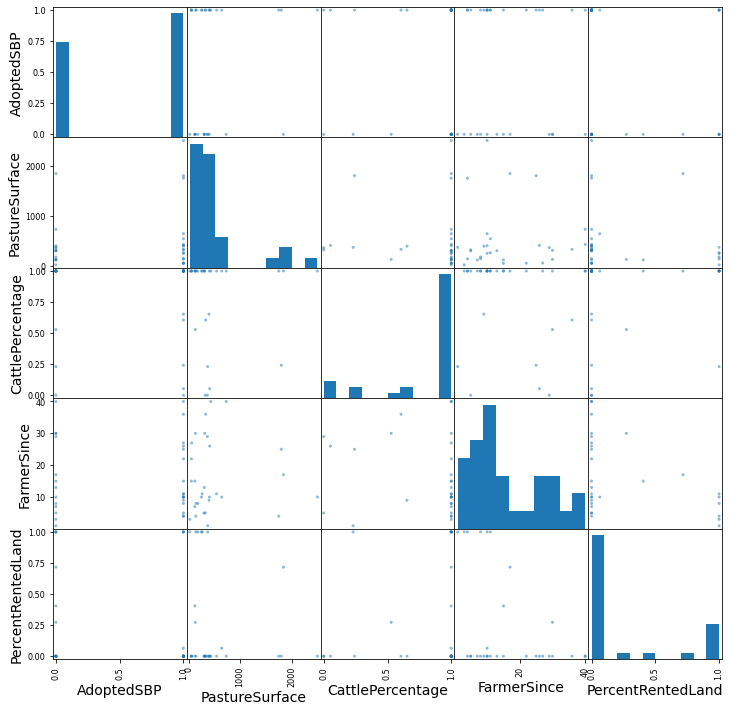

In [174]:
from pandas.plotting import scatter_matrix

attributes = ['AdoptedSBP', 'PastureSurface', 'CattlePercentage', 'FarmerSince', 'PercentRentedLand']
#attributes = ['AdoptedSBP', 'PastureSurface', 'PercentRentedLand']
scatter_matrix(farms30[attributes], figsize=(12, 12))

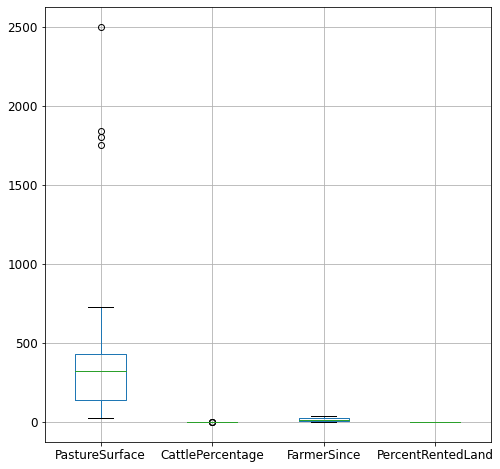

In [178]:
farms31.boxplot(figsize=(8,8)) #to scale before